<a href="https://colab.research.google.com/github/nchadburn/Stat598-FinalProject/blob/main/MLPA%20PCA%2C%20Lasso%2C%20Ridge-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# finanance data
import yfinance as yf

#visualization
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

#date manipulation
from datetime import datetime
import pandas as pd
import numpy as np

#Autoreg and Arima models
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor


# statstical testing, plotting and decompositions
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from scipy import stats

from sklearn.covariance import GraphicalLasso
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline



import networkx as nx

In [41]:
start_date = '2020-06-01'
end_date = '2023-12-01'
etf_ticker = 'MLPA'
moving_average_list = []
etf_tickers_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/mlpa_full-holdings.csv"
crude_oil_stock_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/crude%20oil%20spot%20price.csv"



https://www.eia.gov/dnav/pet/pet_pri_spt_s1_d.htm
pulled crude price oil from this


In [42]:
df_holdings = pd.read_csv(etf_tickers_url)
df_holdings = df_holdings[(df_holdings['Name'] != 'OTHER PAYABLE & RECEIVABLES') & (df_holdings['Name'] != 'CASH')]

df_holdings[f'Market Value ($)'] = df_holdings[f'Market Value ($)'].str.replace(',', '').astype(float)
total_market_value = df_holdings[f'Market Value ($)'].sum()
df_holdings['Percentage Holdings By Value'] = (df_holdings[f'Market Value ($)'] / total_market_value)
df_holdings

,% of Net Assets,Ticker,Name,SEDOL,Market Price ($),Shares Held,Market Value ($),Percentage Holdings By Value
0,20.87,ET,ENERGY TRANSFER LP,B0WHXD2,13.33,"22,735,436.84",3.030634e+08,2.004323e-01
1,13.76,EPD,ENTERPRISE PRODU,2285388,26.25,"7,611,951.00",1.998137e+08,1.321477e-01
2,12.17,MPLX,MPLX LP,B847R56,35.87,"4,925,004.00",1.766599e+08,1.168348e-01
3,10.80,PAA,PLAINS ALL AMER,2311960,14.95,"10,486,658.00",1.567755e+08,1.036842e-01
4,10.32,WES,WESTERN MIDSTREA,BJ552C8,28.24,"5,303,028.00",1.497575e+08,9.904279e-02
5,9.47,ENLC,ENLINK MIDSTREAM LLC,BJTNDQ9,12.81,"10,731,120.00",1.374656e+08,9.091352e-02
6,8.26,CQP,CHENIERE ENERGY,B1VNH36,59.30,"2,023,409.00",1.199882e+08,7.935470e-02
7,6.53,NS,NUSTAR ENERGY LP,2738804,19.00,"4,991,913.00",9.484635e+07,6.272705e-02
8,5.91,HESM,HESS MIDSTREAM-A,BKPK695,30.70,"2,795,220.00",8.581325e+07,5.675298e-02
9,4.53,GEL,GENESIS ENERGY L.P.,2372257,12.32,"5,334,251.00",6.571797e+07,4.346287e-02


In [43]:
df_crude_price = pd.read_csv(crude_oil_stock_url,usecols=[0, 1])

df_crude_price['Date'] = pd.to_datetime(df_crude_price['Date'], format='%b %d, %Y')
df_crude_price.set_index('Date', inplace=True)
df_crude_price.rename(columns={'WTI Barrell Spot Price':'Spot Price'}, inplace=True)

df_crude_price['Spot Price'] = df_crude_price['Spot Price'].fillna(method='ffill')



In [44]:

all_stocks_data = yf.download(etf_ticker, start=start_date, end=end_date)
#join spot price and etf
all_stocks_data['Ticker'] = etf_ticker
all_stocks_data.columns = [f'{etf_ticker}_{col}' if col not in ['Ticker', 'Date'] else col for col in all_stocks_data.columns]
all_stocks_data = all_stocks_data.join(df_crude_price, how='left')




[*********************100%%**********************]  1 of 1 completed


In [45]:
all_stocks_data

,MLPA_Open,MLPA_High,MLPA_Low,MLPA_Close,MLPA_Adj Close,MLPA_Volume,Ticker,Spot Price
Date,,,,,,,,
2020-06-01,29.770000,30.030001,29.270000,29.459999,21.973854,251400,MLPA,35.49
2020-06-02,29.790001,30.209999,29.570000,30.150000,22.488512,384200,MLPA,36.88
2020-06-03,30.280001,31.430000,30.280001,31.190001,23.264236,596100,MLPA,37.33
2020-06-04,30.940001,31.969999,30.900000,31.940001,23.823654,508200,MLPA,37.42
2020-06-05,32.910000,33.910000,32.910000,33.560001,25.031992,510700,MLPA,39.49
...,...,...,...,...,...,...,...,...
2023-11-24,45.310001,45.450001,45.029999,45.200001,45.200001,32500,MLPA,74.83
2023-11-27,45.250000,45.330002,45.009998,45.250000,45.250000,48900,MLPA,74.46
2023-11-28,45.250000,45.259998,44.799999,45.250000,45.250000,91800,MLPA,76.09


In [46]:
# load all tickers part of that etf
for ticker in df_holdings['Ticker']:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    percentage_holding = df_holdings.loc[df_holdings['Ticker'] == ticker, 'Percentage Holdings By Value'].iloc[0]
    all_stocks_data[f'{ticker}_Percent_Holding'] = percentage_holding
    stock_data.columns = [f'{ticker}_{col}' if col != 'Ticker' else col for col in stock_data.columns]

    all_stocks_data = all_stocks_data.join(stock_data, how='outer')

all_stocks_data.fillna(0, inplace=True)


sum_values = pd.Series(0, index=all_stocks_data.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [47]:
#graphical lasso

all_stocks_data[f'{etf_ticker}_Next_Close'] = all_stocks_data[f'{etf_ticker}_Close'].shift(-1)
all_stocks_data = all_stocks_data.drop(all_stocks_data.index[-1])
close_values = all_stocks_data[[col for col in all_stocks_data.columns if '_Close' in col or col == 'Spot Price' or col == f'{etf_ticker}_Next_Close']]

print(close_values.columns)



Index(['MLPA_Close', 'Spot Price', 'ET_Close', 'EPD_Close', 'MPLX_Close',
       'PAA_Close', 'WES_Close', 'ENLC_Close', 'CQP_Close', 'NS_Close',
       'HESM_Close', 'GEL_Close', 'DKL_Close', 'PSX_Close', 'MLPX_Close',
       'CAPL_Close', 'SMLP_Close', 'GPP_Close', 'NGL_Close', 'MMLP_Close',
       'SNMP_Close', 'USDP_Close', 'MLPA_Next_Close'],
      dtype='object')


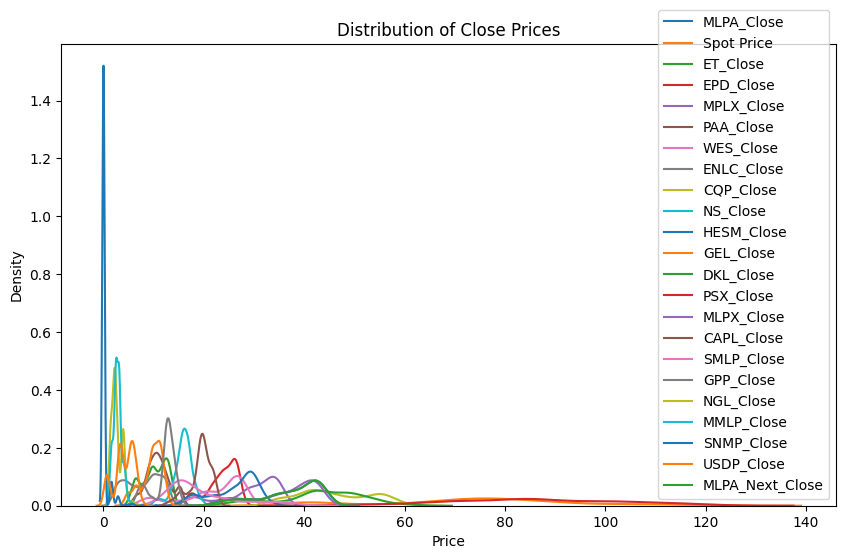

In [48]:
plt.figure(figsize=(10, 6))
for col in close_values.columns:
    sns.kdeplot(close_values[col], label=col)

plt.title('Distribution of Close Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()



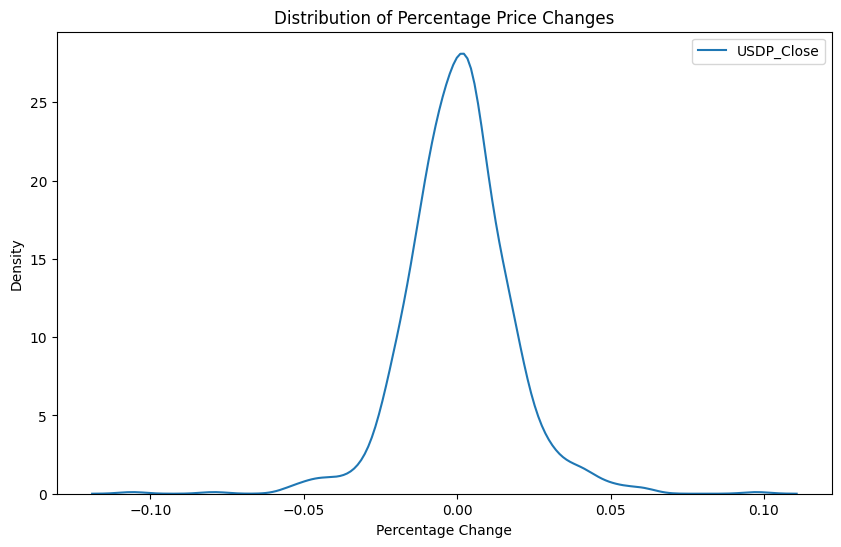

In [70]:
df_price_change = np.log1p(all_stocks_data[f'{etf_ticker}_Close']).pct_change()

df_price_change = all_stocks_data[f'{etf_ticker}_Close'].pct_change()


plt.figure(figsize=(10, 6))
sns.kdeplot(df_price_change, label=col)

plt.title('Distribution of Percentage Price Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Density')
plt.legend()
plt.show()

In [50]:
etf_mean = df_price_change.mean()
etf_std = df_price_change.std()
etf_mean, etf_std

(0.0006375668541905813, 0.016977419163722685)

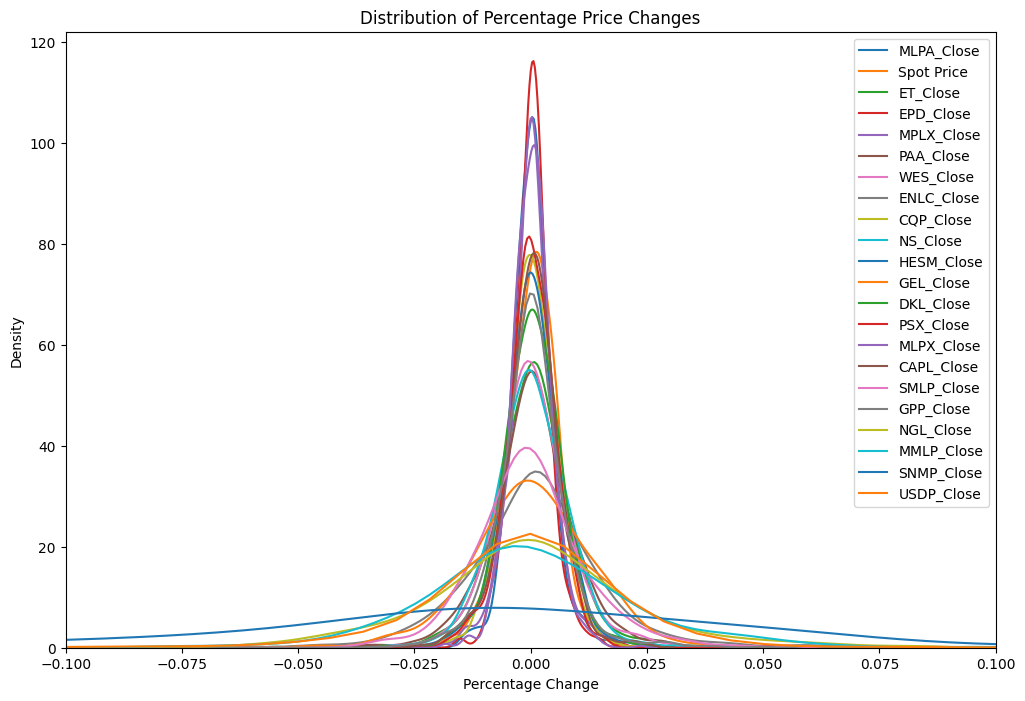

In [68]:


df_holding_close_prices = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

holding_pct_change = np.log1p(df_holding_close_prices).pct_change().iloc[1:]


plt.figure(figsize=(12, 8))
for col in holding_pct_change.columns:
    sns.kdeplot(holding_pct_change[col], label=col)

plt.title('Distribution of Percentage Price Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Density')
plt.xlim(-0.1, 0.1)
plt.legend()
plt.show()




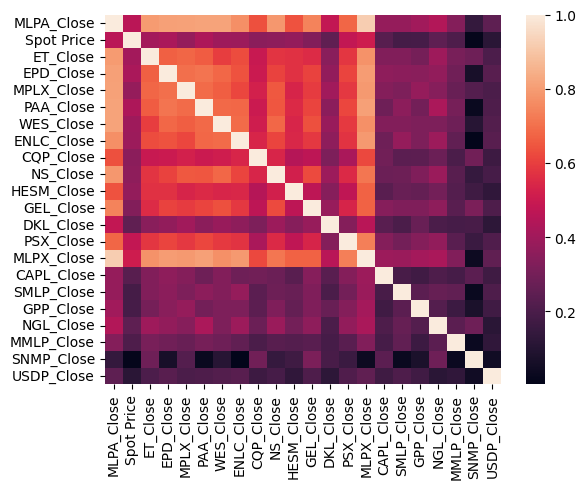

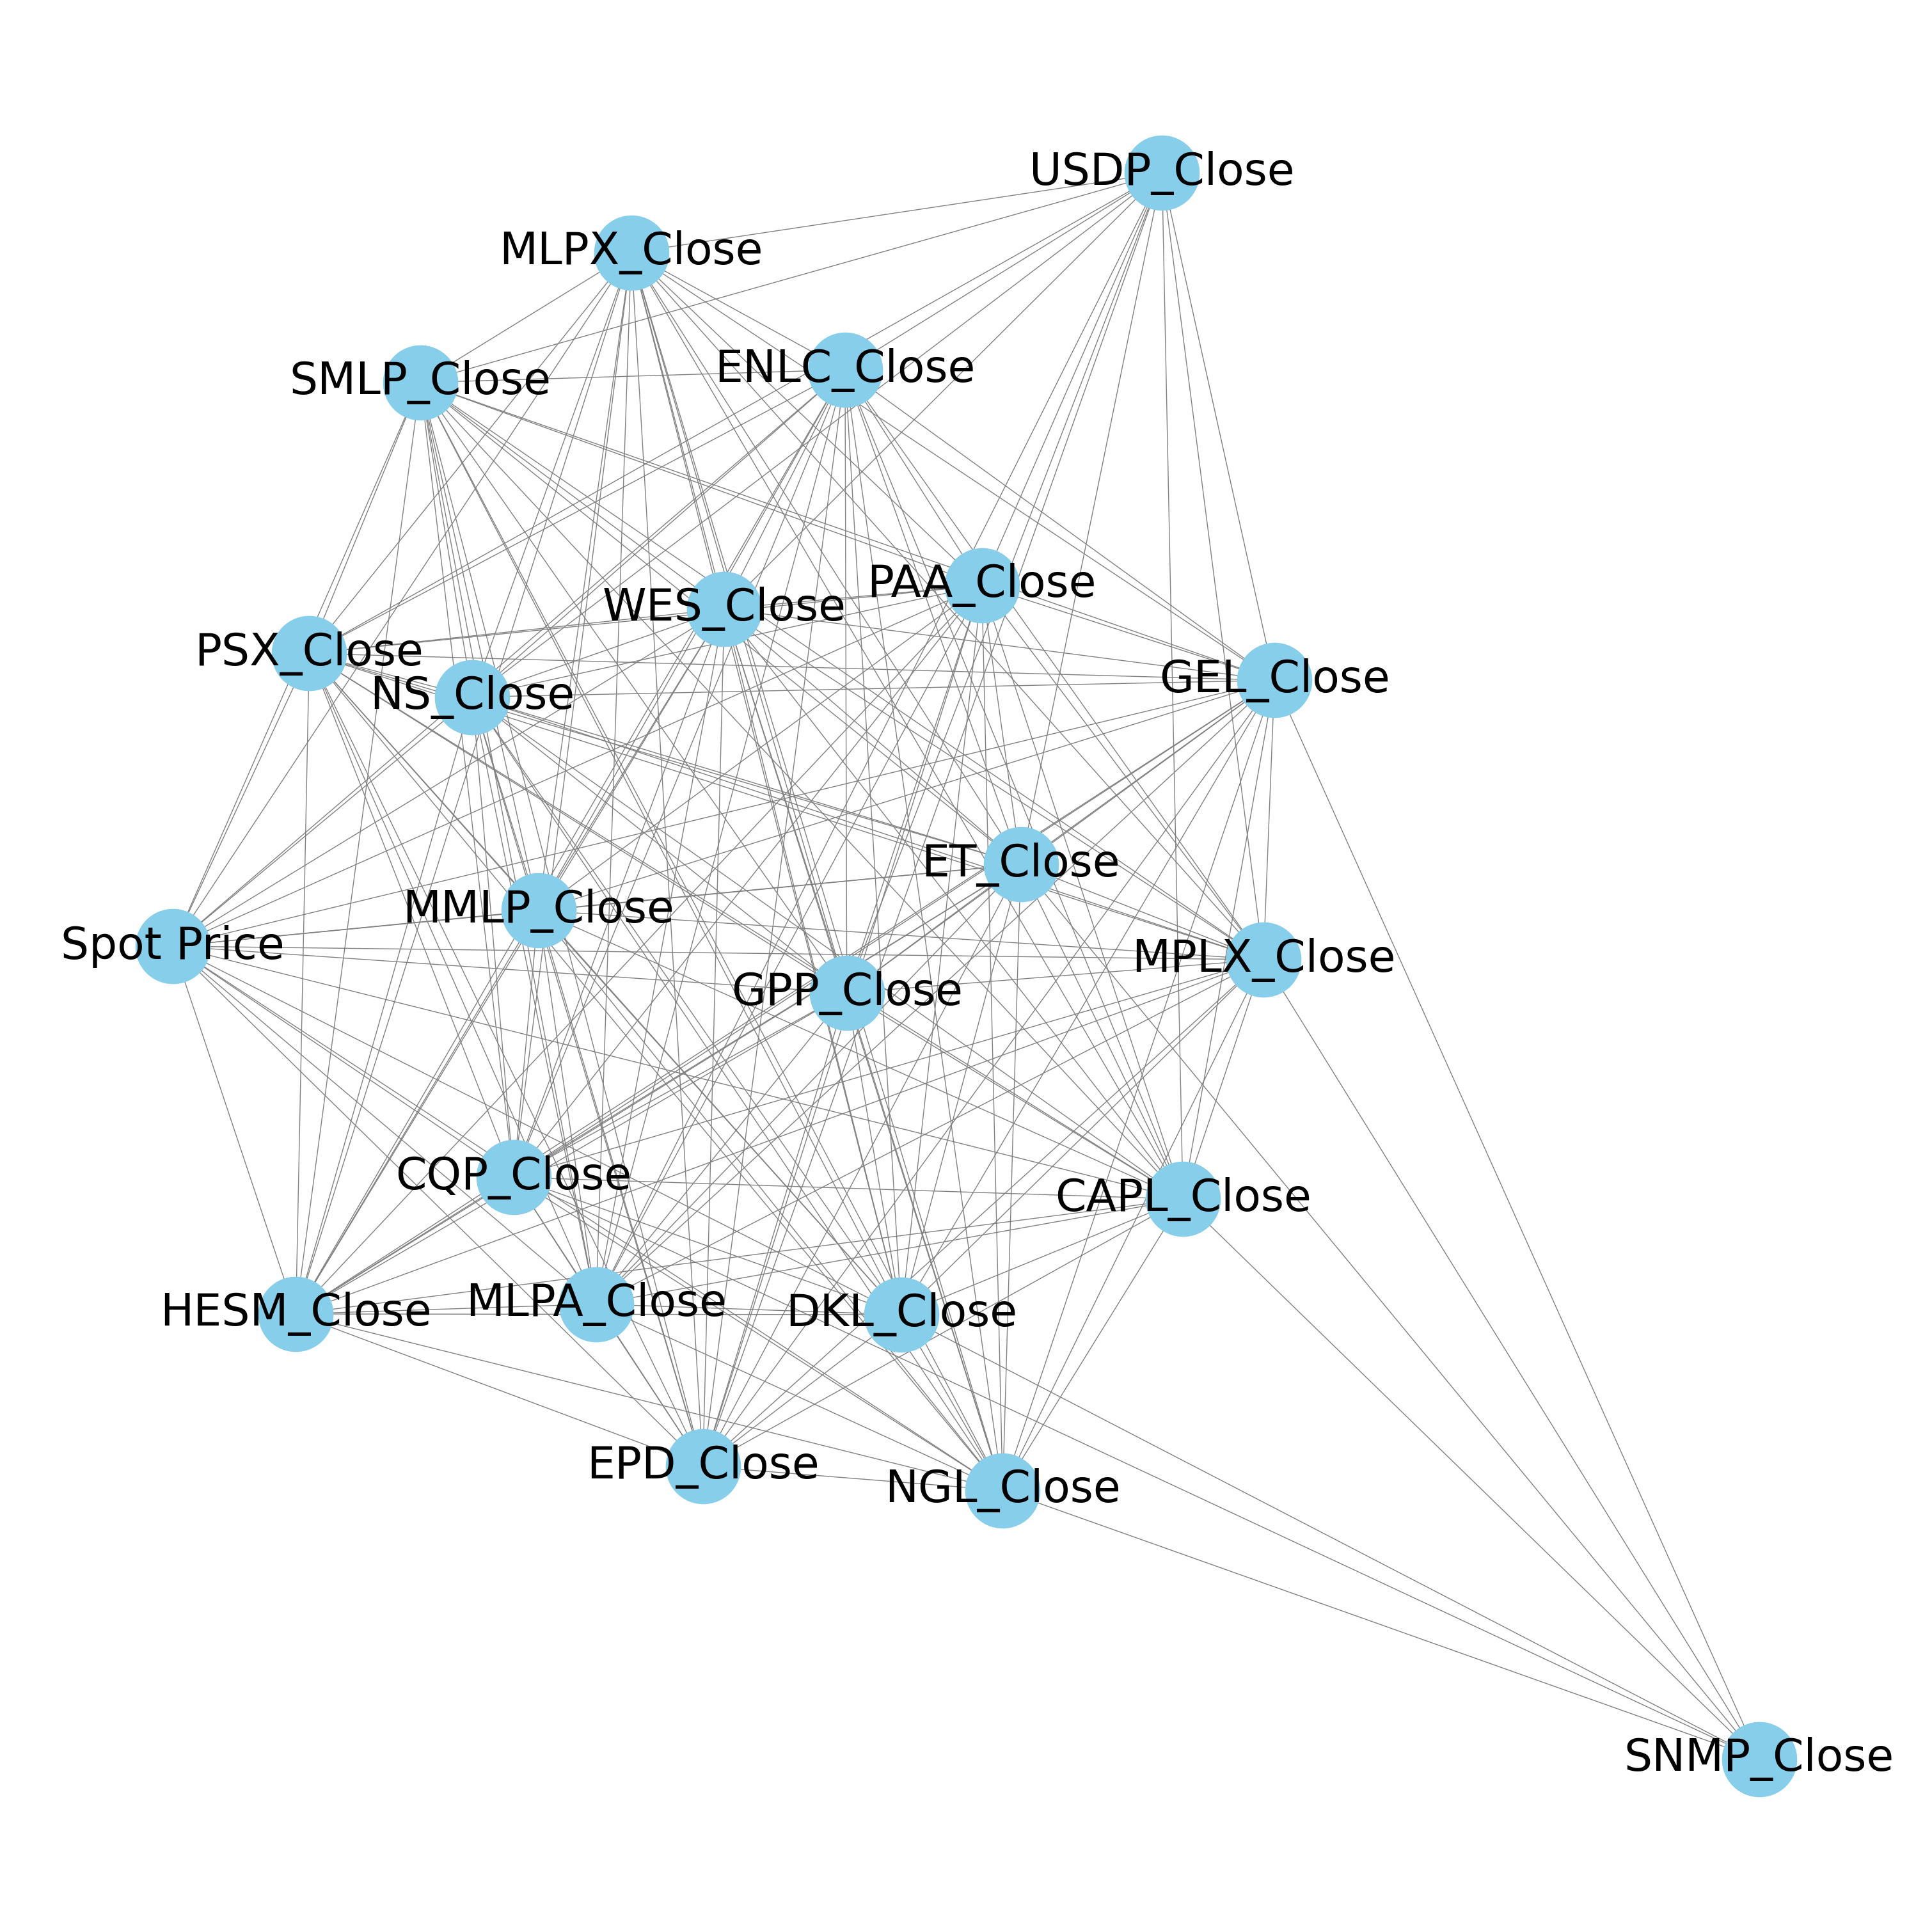

In [81]:


features = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

df = np.log1p(features.pct_change()).iloc[1:]


p = df.corr()
sns.heatmap(p)

cols = df.columns
p_df = pd.DataFrame(p, columns=cols, index=cols)
links = p_df.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
links = links.loc[(abs(links['value']) > 0.17) & (links['var1'] != links['var2'])]

G = nx.from_pandas_edgelist(links, 'var1', 'var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=50)
plt.figure(3, figsize=(30, 30))
nx.draw(G, pos=pos, with_labels=True, node_size=7000, node_color="skyblue", font_size=50, edge_color="grey")
plt.show()

nx.write_gexf(G, 'graph.gexf')


https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7


https://towardsdatascience.com/porting-ideas-to-math-a-step-by-step-derivation-of-graphical-lasso-2e01f7165d95


In [53]:

pca_list = list()
features = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

pca_list = []
feature_weight_list = []

for n in range(1, 6):
    PCAmod = PCA(n_components=n)
    PCAmod.fit(features)
    pca_list.append(pd.Series({'n': n, 'model': PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))

    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n': n, 'features': features.columns,
                                             'values': abs_feature_values / abs_feature_values.sum()}))

pca_df = pd.concat(pca_list, axis=1).T.set_index('n')

print(pca_df)


                 model       var
n                               
1  PCA(n_components=1)  0.765977
2  PCA(n_components=2)  0.900394
3  PCA(n_components=3)  0.948938
4  PCA(n_components=4)  0.974053
5  PCA(n_components=5)  0.983975


90% of total variation is explained by the first two components


In [54]:

train, test = train_test_split(close_values, test_size=0.8, random_state=42)

feature_columns = [col for col in all_stocks_data.columns if ('_Close' in col or 'Spot' in col) and etf_ticker not in col]
features = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

lr = LinearRegression()
X = close_values.drop(f'{etf_ticker}_Next_Close', axis=1)
y = close_values[f'{etf_ticker}_Next_Close']

X_train = train[feature_columns]
y_train = train[f'{etf_ticker}_Next_Close']

X_test  = test[feature_columns]
y_test  = test[f'{etf_ticker}_Next_Close']

pipe = [
    ('pca', PCA(n_components=n)),
    ('regression', lr)]

pipe = Pipeline(pipe)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')
PCA_r2 = r2_score(y_pred, y_test)
PCA_r2
print(f'PCA regression: {PCA_r2}')

MSE: 1.4977464212088623
PCA regression: 0.9588331963131125


In [55]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]


ridgeCV = RidgeCV(alphas=alphas,
                  cv=4).fit(X_train, y_train)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print("The best alpha is: {} with Root Mean Square Error: {}".format(
                                        ridgeCV.alpha_, ridgeCV_rmse))

lassoCV = LassoCV(alphas=None, cv=4, max_iter=10000)
lassoCV.fit(X_train, y_train)
LASSO_1_r2 = r2_score(y_test, lassoCV.predict(X_test))
print("R² Score for LassoCV model: ", LASSO_1_r2)

The best alpha is: 5.0 with Root Mean Square Error: 0.7108431700823182
R² Score for LassoCV model:  0.985866663650861


https://medium.com/the-quant-journey/pca-regression-on-etf-data-9d939c33fea9

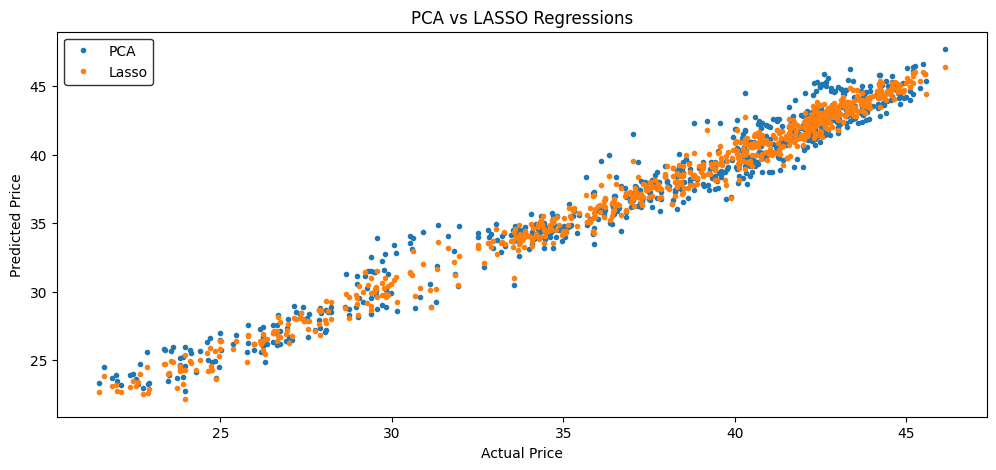

In [56]:
f = plt.figure(figsize=(12,5))
ax = plt.axes()

pipe = [
    ('pca', PCA(n_components=n)),
    ('regression', lr)
]
pipe = Pipeline(pipe)

labels = ['PCA', 'Lasso']

models = [pipe.fit(X_train, y_train), lassoCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test),
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price',
       ylabel='Predicted Price',
       title='PCA vs LASSO Regressions');